## COVID-19 Image Recognition Pretrained Models - First Run

###Introduction
###DenseNet169
###VGG16
###ResNet50
###InceptionV3
###DenseNet169 with ModelCheckpoint
###InceptionV3 with ModelCheckpoint
###InceptionResNetV2
###InceptionV3 with Imagenet Weights
###InceptionResNetV2 with Imagenet Weights


### Introduction

In the first phase of this project, we created an initial model that achieved over 90% accuracy in just 15 epochs. In this next phase, we'll be testing several pretrained models - DenseNet169, InceptionV3, ResNet50, VGG16, and InceptionResNetV2 - in hopes that at least one of them can achieve a higher accuracy than our inital model. In a separate notebook, we'll complete the project by tuning the strongest of these models.  

A little background in case you haven't viewed the notebook containing the inital model:

This project is influenced by Thomas Mann's The Magic Mountain, in which protagonist Hans Castorp spends seven years at a sanatorium that treats tuberculosis patients in the early part of the 20th century. Mann describes the chest x-ray images of patients in great detail, with Dr. Behrens explaining to Hans Castorp which telltale signs in the images indicate tuberculosis. 

While tuberculosis is still a significant ailment in many parts of the world, this project is concerned with a more topical disease - COVID-19. While there are several tests available to test for COVID-19, x-ray imaging still plays a vital role in understanding the damage that COVID can wreak on a patient's lungs.  

COVID can cause patients to develop pneumonia. There is a great deal of research being done to determine how COVID based pnuemonia differs from non-COVID pnuemonia. While COVID and non-COVID pneumonias are both viral, there are some distinguishing features of the COVID variety, including a ground glass appearance on CT scans and that it affects both lungs rather than just one (non-COVID pneumonias can also effect both lungs, but less consistently). 

This project will attempt to train a model to distinuish among the lungs of COVID, viral (non-COVID) pneumonia, and healthy patients (or at least those that don't have either type of pneumonia). 

We'll be working with over 3800 images collected from a variety of sources, all of which can be found here:
https://www.kaggle.com/tawsifurrahman/covid19-radiography-database



As we did previously, let's begin by loading any libraries we may need, including tensorflow, keras, pandas, numpy, and matplotlib.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Add a couple of random seeds to make our outcomes more consistent.

In [3]:
# Random seeds from both numpy and tensorflow
from numpy.random import seed
seed(99)
tf.random.set_seed(99)   

Since this is being done on Colab, we'll mount the images from Google Drive. There are other ways to also load the images, depending on which application you're using.

In [4]:
# Mount Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As a reminder, the following sets of images are chest x-rays of COVID patients, followed by pneumonia and healthy (labeled as NORMAL) patients.

Display Random Images


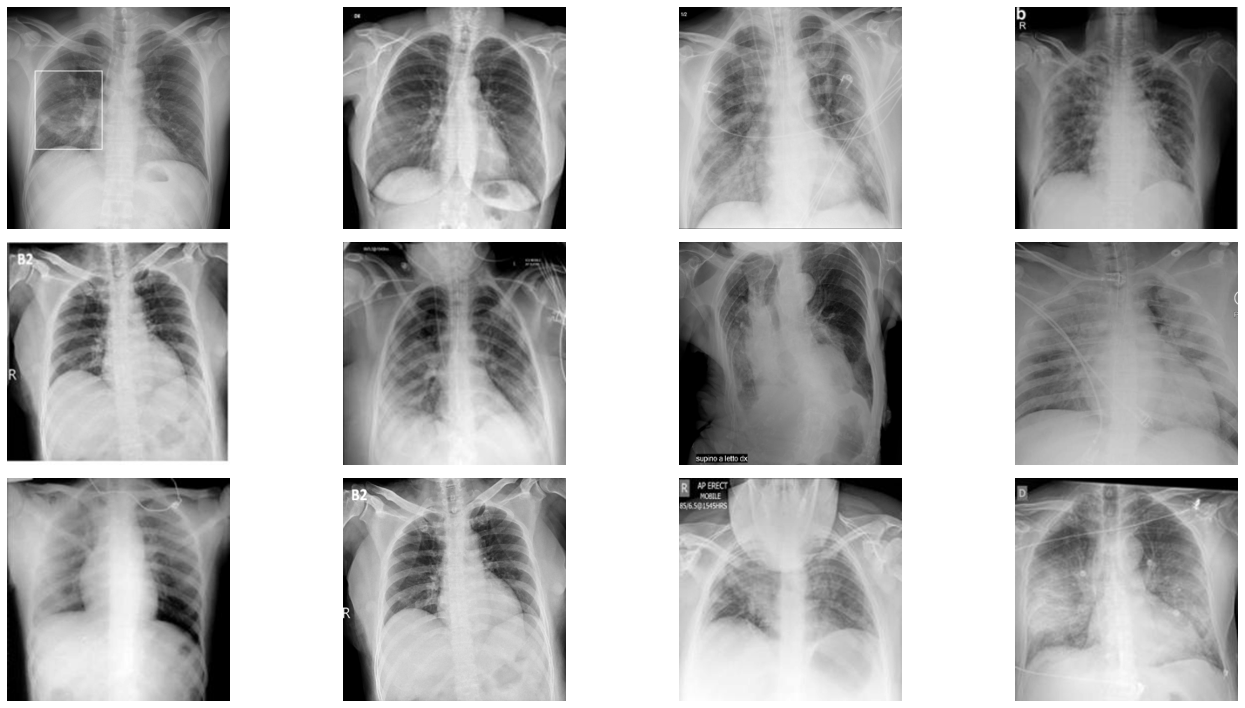

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/COVID"
image_files = os.listdir(path)


print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display Random Images


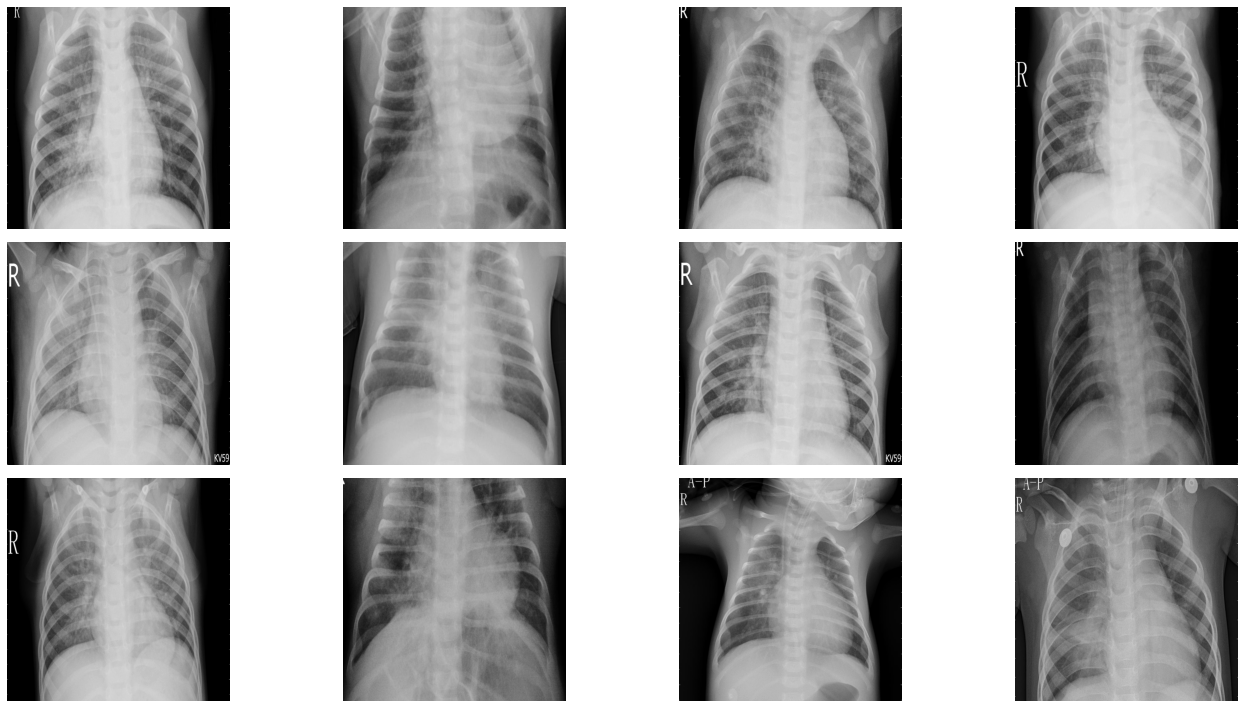

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/Viral Pneumonia"
image_files = os.listdir(path)


print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

Display Random Images


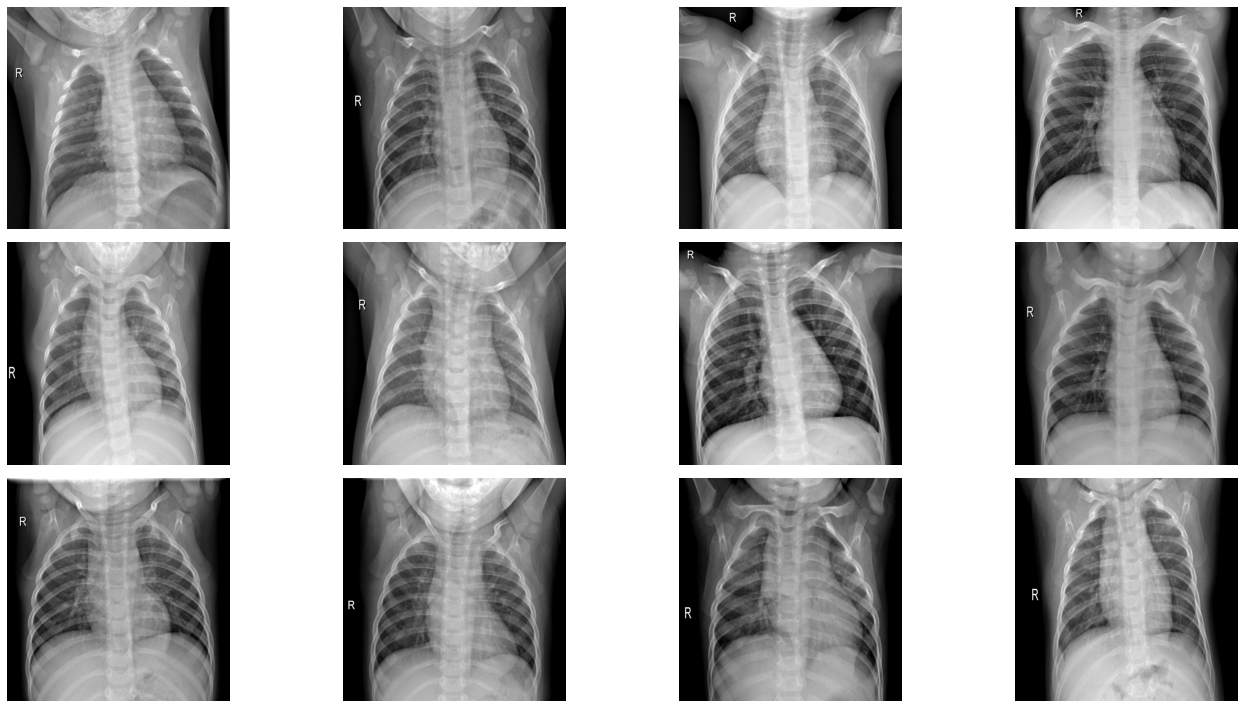

In [ ]:
# Location of images
path = "/content/drive/MyDrive/COVID-19 Radiography Database/train/NORMAL"
image_files = os.listdir(path)


print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Select and display random images
for i in range(12):
    plt.subplot(3, 4, i + 1)
    img = plt.imread(os.path.join(path, image_files[random.randrange(0, len(image_files))]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

As we can see, there are some similarities between the COVID and pneumonia patients, particularly with regard to the cloudy appearance of the scans. However, the COVID patients on average seem to have the cloudiest images, while the healthy patients have the clearest.

In [5]:
# Import ImageDataGenerator to allow us to create batches and perform data augmentation
from keras.preprocessing.image import ImageDataGenerator

In [6]:
# Rescale the images
train_data_generator = ImageDataGenerator(rescale=1./255)
valid_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [7]:
# Paths to access the correct image folders
train_path = '/content/drive/MyDrive/COVID-19 Radiography Database/train'
valid_path = '/content/drive/MyDrive/COVID-19 Radiography Database/validation'
test_path = '/content/drive/MyDrive/COVID-19 Radiography Database/test'

We'll now use image generator to define where our train, validation, and test images are found as well as to dictate image size and batch size. The orignal images size is 256 x 256, most of our pretrained models work with 224 x 224 images. We're running a 60/20/20 split (train/validation/test).  

In [8]:
train_batches = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(224, 224), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(224, 224), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(224, 224), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In a previous runthrough with all of the following pretrained models - except for InceptionV3 and InceptionResNetV2 - as they were late additions to the notebook - we used Imagenet weights and while the training accuracy was largely high, the validation accuracy was very low. This time, we'll try running all of the models without Imagenet weights. Later, we'll use Imagenet with the two Inception models that we have not tested yet.

In [9]:
# Function to graph training and validation accuracy/loss results
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.figure(figsize=(15, 7))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title('Training and validation')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

###DenseNet169

We'll now begin training our pretrained models, starting with DenseNet169. For the sake of consistency,  we'll add all of the same additionall layers - a flattening layer, a dense layer with ReLu activation, and, finally, a dense layer with Softmax activation. We'll also use an Adam optimizer with a 0.01 learning rate and categorical crossentropy loss.  

In [ ]:
dn1692 = tf.keras.applications.DenseNet169(
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
model_dn = tf.keras.Sequential()
model_dn.add(dn1692)
model_dn.add(tf.keras.layers.Flatten())
model_dn.add(tf.keras.layers.Dense(256, activation='relu'))
model_dn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_dn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 81536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               20873472  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 33,517,123
Trainable params: 33,358,723
Non-trainable params: 158,400
_________________________________________________________________


In [ ]:
model_dn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# fit/train the model using the images and labels
%%time

history = model_dn.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=15,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      verbose=1)

Epoch 1/15
73/73 [==============================] - 735s 10s/step - loss: 5.1494 - accuracy: 0.7504 - val_loss: 51924260.0000 - val_accuracy: 0.3093
Epoch 2/15
73/73 [==============================] - 45s 615ms/step - loss: 0.4185 - accuracy: 0.9204 - val_loss: 20785.6250 - val_accuracy: 0.3183
Epoch 3/15
73/73 [==============================] - 45s 615ms/step - loss: 0.3101 - accuracy: 0.9440 - val_loss: 11094.1094 - val_accuracy: 0.3273
Epoch 4/15
73/73 [==============================] - 45s 616ms/step - loss: 0.2750 - accuracy: 0.9364 - val_loss: 5675.0728 - val_accuracy: 0.3093
Epoch 5/15
73/73 [==============================] - 45s 619ms/step - loss: 0.9837 - accuracy: 0.9235 - val_loss: 0.5921 - val_accuracy: 0.8273
Epoch 6/15
73/73 [==============================] - 45s 620ms/step - loss: 1.1379 - accuracy: 0.8775 - val_loss: 1449.4164 - val_accuracy: 0.3711
Epoch 7/15
73/73 [==============================] - 46s 622ms/step - loss: 0.2277 - accuracy: 0.9463 - val_loss: 1.0937 - 

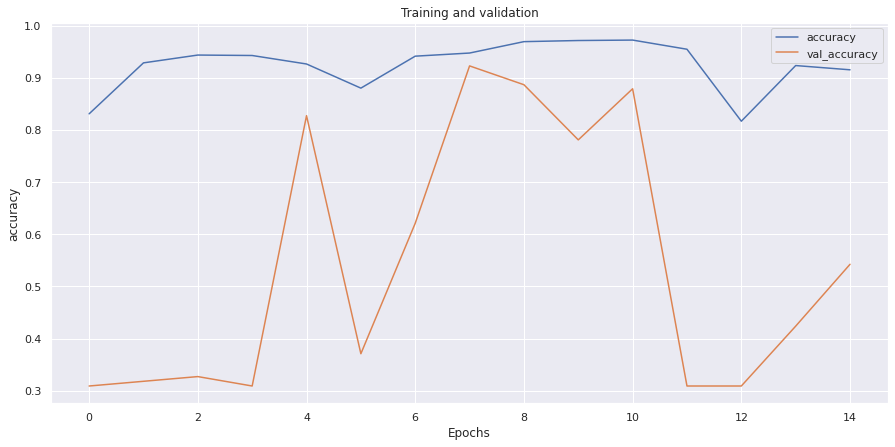

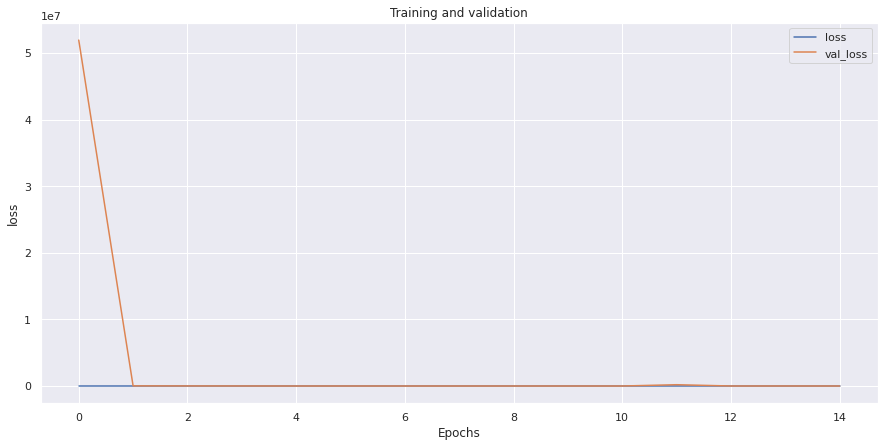

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_dn.save("dn1692_model")

INFO:tensorflow:Assets written to: dn1692_model/assets


In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
dn1692_model = load_model('dn1692_model')

In [ ]:
# Runninng the model on the test set
test_loss, test_acc = dn1692_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 177s 7s/step - loss: 0.9191 - accuracy: 0.5329
test loss: 0.9190874099731445
test acc: 0.532903254032135


Our test accuracy was fairly low, but the model did show some promise in its validation accuracy. So, we'll train this model later again using the ModelCheckpoint callback to save and use the best weights on the test set.

Next up is VGG16.

###VGG16

In [ ]:
vgg16 = tf.keras.applications.VGG16(
                  include_top=False,
                  input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
#Adjust several layers
model_vgg = tf.keras.Sequential()
model_vgg.add(vgg16)
model_vgg.add(tf.keras.layers.Flatten())
model_vgg.add(tf.keras.layers.Dense(256, activation='relu'))
model_vgg.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

history = model_vgg.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=15,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      verbose=1)

Epoch 1/15
73/73 [==============================] - 54s 672ms/step - loss: 3.0129 - accuracy: 0.3438 - val_loss: 1.0924 - val_accuracy: 0.3492
Epoch 2/15
73/73 [==============================] - 45s 610ms/step - loss: 1.0921 - accuracy: 0.3887 - val_loss: 1.0975 - val_accuracy: 0.3441
Epoch 3/15
73/73 [==============================] - 45s 611ms/step - loss: 1.0969 - accuracy: 0.3412 - val_loss: 1.0974 - val_accuracy: 0.3441
Epoch 4/15
73/73 [==============================] - 45s 610ms/step - loss: 1.0985 - accuracy: 0.3448 - val_loss: 1.0973 - val_accuracy: 0.3466
Epoch 5/15
73/73 [==============================] - 45s 609ms/step - loss: 1.0981 - accuracy: 0.3162 - val_loss: 1.0973 - val_accuracy: 0.3466
Epoch 6/15
73/73 [==============================] - 45s 611ms/step - loss: 1.0979 - accuracy: 0.3298 - val_loss: 1.0973 - val_accuracy: 0.3466
Epoch 7/15
73/73 [==============================] - 45s 611ms/step - loss: 1.0956 - accuracy: 0.3548 - val_loss: 1.0973 - val_accuracy: 0.3466

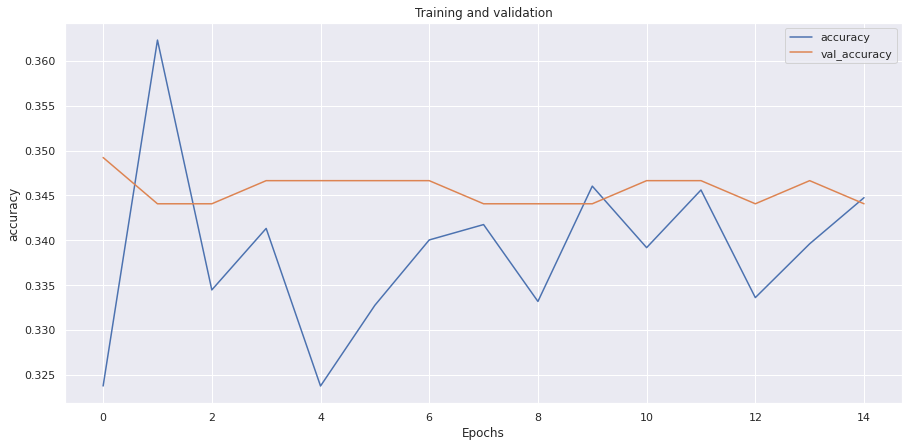

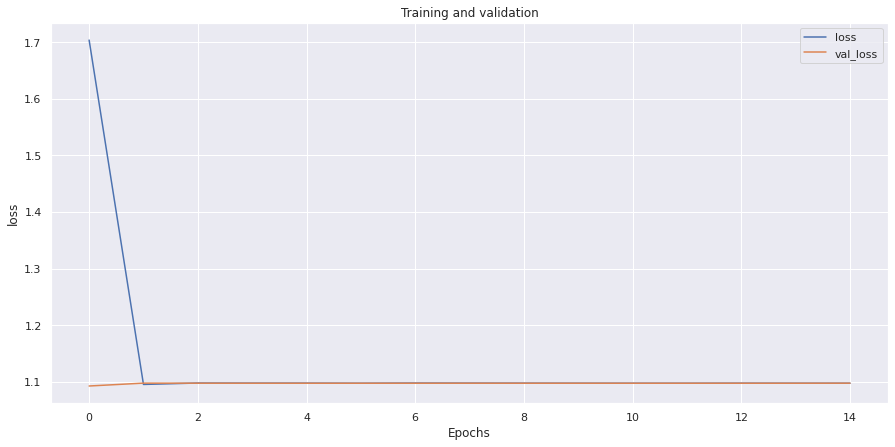

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_vgg.save("vgg16_model")

INFO:tensorflow:Assets written to: vgg16_model/assets


In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
vgg16_model = load_model('vgg16_model')

In [ ]:
# Running the model on the test set
test_loss, test_acc = vgg16_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 12s 454ms/step - loss: 1.0974 - accuracy: 0.3432
test loss: 1.0974493026733398
test acc: 0.3432258069515228


It appears that we can drop this model from our list of candidates. It performed poorly in training, validation, and testing. 

Let's move onto ResNet50.

###Resnet50

In [ ]:
# Load the ResNet50 model
#from keras.applications import ResNet50

rn50 = tf.keras.applications.ResNet50(
                  include_top=False,
                  input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#Adjust several layers
model_rn = tf.keras.Sequential()
model_rn.add(rn50)
model_rn.add(tf.keras.layers.Flatten())
model_rn.add(tf.keras.layers.Dense(256, activation='relu'))
model_rn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_rn.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

history = model_rn.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=15,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      verbose=1)

Epoch 1/15
73/73 [==============================] - 51s 623ms/step - loss: 6.0348 - accuracy: 0.8348 - val_loss: 18748516.0000 - val_accuracy: 0.3093
Epoch 2/15
73/73 [==============================] - 44s 595ms/step - loss: 1.7249 - accuracy: 0.8952 - val_loss: 1.1000 - val_accuracy: 0.3093
Epoch 3/15
73/73 [==============================] - 43s 593ms/step - loss: 0.4615 - accuracy: 0.9072 - val_loss: 1.1022 - val_accuracy: 0.3466
Epoch 4/15
73/73 [==============================] - 44s 597ms/step - loss: 0.3511 - accuracy: 0.9416 - val_loss: 1.2676 - val_accuracy: 0.3093
Epoch 5/15
73/73 [==============================] - 43s 592ms/step - loss: 0.1273 - accuracy: 0.9694 - val_loss: 1.2988 - val_accuracy: 0.1005
Epoch 6/15
73/73 [==============================] - 44s 594ms/step - loss: 0.0750 - accuracy: 0.9741 - val_loss: 3.6462 - val_accuracy: 0.3093
Epoch 7/15
73/73 [==============================] - 44s 595ms/step - loss: 0.0456 - accuracy: 0.9849 - val_loss: 9.3951 - val_accuracy:

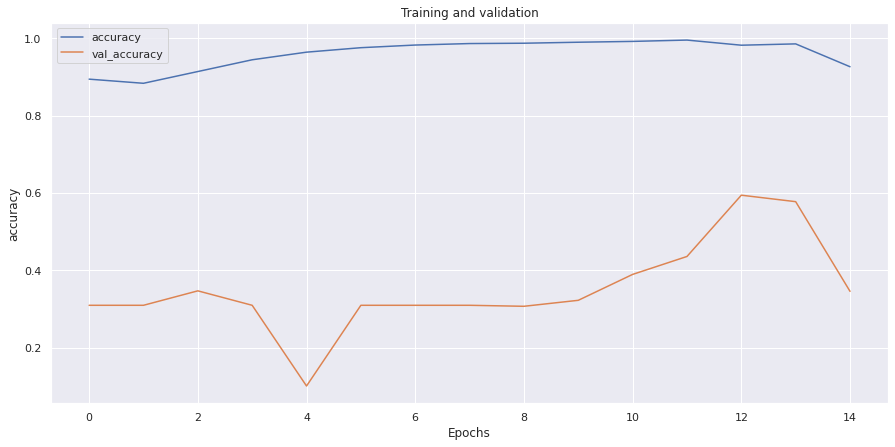

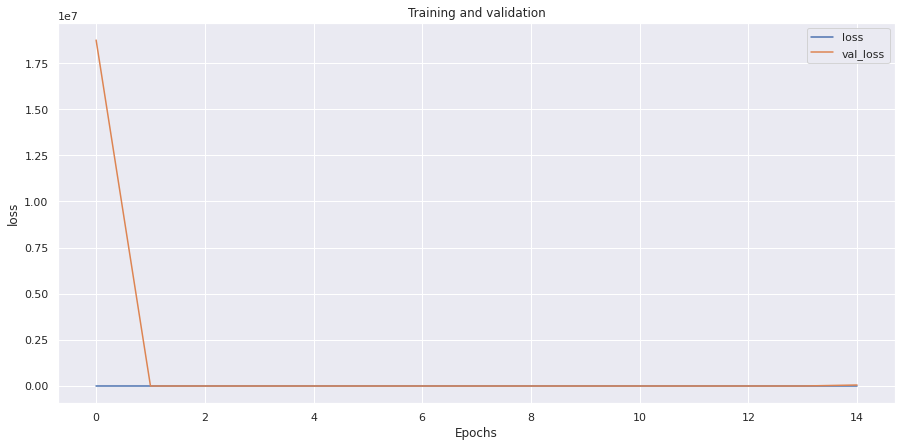

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_rn.save("rn50_model")

INFO:tensorflow:Assets written to: rn50_model/assets


In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
rn50_model = load_model('rn50_model')

In [ ]:
# Running the model on the test set
test_loss, test_acc = rn50_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 12s 440ms/step - loss: 55386.0078 - accuracy: 0.3432
test loss: 55386.0078125
test acc: 0.3432258069515228


While ResNet50's training accuracy was very high, it performed poorly on the validation set as well as the test set, suggesting a high degree of overfitting. Given that we already have two models thusfar that have performed much better, we'll also drop ResNet50 because it doesn't seem worth the effort to tune it.

Next, we have InceptionV3.

###InceptionV3

In [ ]:
iv3 = tf.keras.applications.InceptionV3(
                  include_top=False,
                  input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#Adjust several layers
model_iv3 = tf.keras.Sequential()
model_iv3.add(iv3)
model_iv3.add(tf.keras.layers.Flatten())
model_iv3.add(tf.keras.layers.Dense(256, activation='relu'))
model_iv3.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_iv3.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit/train the model using the images and labels
%%time

history = model_iv3.fit(
      train_batches,
      steps_per_epoch=73,
    
      epochs=15,
    
      # validate the trained model on unseen (validation) images
      validation_data = valid_batches,
      validation_steps=25,
      verbose=1)

Epoch 1/15
73/73 [==============================] - 54s 640ms/step - loss: 3.2032 - accuracy: 0.7498 - val_loss: 11.3327 - val_accuracy: 0.8802
Epoch 2/15
73/73 [==============================] - 42s 577ms/step - loss: 0.1348 - accuracy: 0.9616 - val_loss: 2.2964 - val_accuracy: 0.7088
Epoch 3/15
73/73 [==============================] - 42s 574ms/step - loss: 0.0641 - accuracy: 0.9776 - val_loss: 0.3335 - val_accuracy: 0.9317
Epoch 4/15
73/73 [==============================] - 42s 568ms/step - loss: 0.0528 - accuracy: 0.9885 - val_loss: 0.1643 - val_accuracy: 0.9497
Epoch 5/15
73/73 [==============================] - 41s 567ms/step - loss: 0.0531 - accuracy: 0.9835 - val_loss: 14.9389 - val_accuracy: 0.8608
Epoch 6/15
73/73 [==============================] - 42s 570ms/step - loss: 0.4336 - accuracy: 0.9611 - val_loss: 335379.2500 - val_accuracy: 0.3093
Epoch 7/15
73/73 [==============================] - 42s 570ms/step - loss: 0.1089 - accuracy: 0.9698 - val_loss: 0.4012 - val_accuracy:

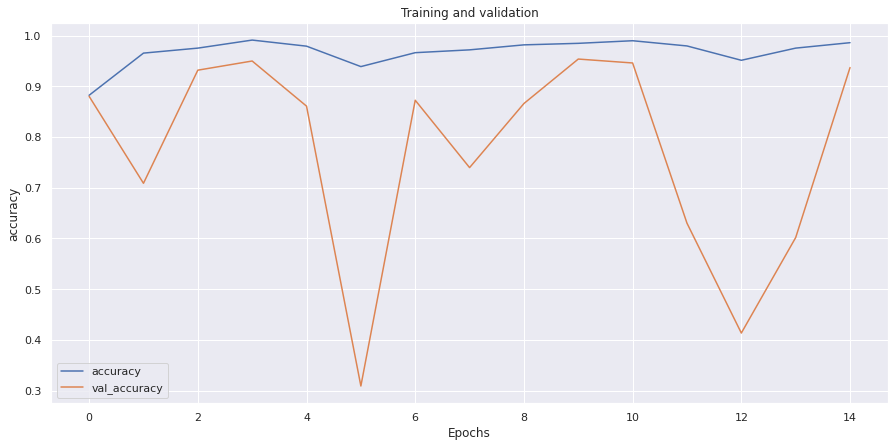

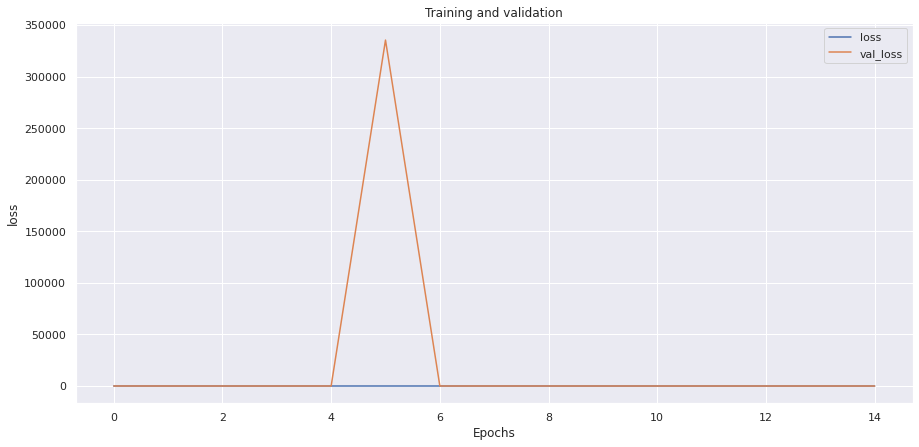

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_iv3.save("iv3_model")

INFO:tensorflow:Assets written to: iv3_model/assets


In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
iv3_model = load_model('iv3_model')

In [ ]:
# Runninng the model on the test set
test_loss, test_acc = iv3_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 13s 450ms/step - loss: 0.2212 - accuracy: 0.9316
test loss: 0.22120238840579987
test acc: 0.9316129088401794


Like DenseNet169, InceptionV3 performed well but had very inconsistent epoch results. So, both models are good candidates for retraining with ModelCheckpoint. We'll start with DenseNet169.

### DenseNet169 with ModelCheckpoint

In [10]:
# Include several callbacks
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger

tensorflow.python.keras.callbacks.CSVLogger

In [ ]:
dn1692 = tf.keras.applications.DenseNet169(
                  include_top=False,
                  input_shape=(224, 224, 3))

51879936/51877672 [==============================] - 1s 0us/step


In [ ]:
model_dn = tf.keras.Sequential()
model_dn.add(dn1692)
model_dn.add(tf.keras.layers.Flatten())
model_dn.add(tf.keras.layers.Dense(256, activation='relu'))
model_dn.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_dn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='dn1692.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_dn.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 65s 711ms/step - loss: 4.9365 - accuracy: 0.7596 - val_loss: 200642272.0000 - val_accuracy: 0.3093

Epoch 00001: val_loss improved from inf to 200642272.00000, saving model to dn1692.h5
Epoch 2/15
73/73 [==============================] - 47s 638ms/step - loss: 3.0044 - accuracy: 0.8518 - val_loss: 9346.8857 - val_accuracy: 0.3338

Epoch 00002: val_loss improved from 200642272.00000 to 9346.88574, saving model to dn1692.h5
Epoch 3/15
73/73 [==============================] - 47s 642ms/step - loss: 2.5461 - accuracy: 0.8611 - val_loss: 580551.4375 - val_accuracy: 0.5619

Epoch 00003: val_loss did not improve from 9346.88574
Epoch 4/15
73/73 [==============================] - 47s 635ms/step - loss: 0.8253 - accuracy: 0.9111 - val_loss: 634.6720 - val_accuracy: 0.4034

Epoch 00004: val_loss improved from 9346.88574 to 634.67200, saving model to dn1692.h5
Epoch 5/15
73/73 [==============================] - 47s 634ms/step - loss: 0.4864 - ac

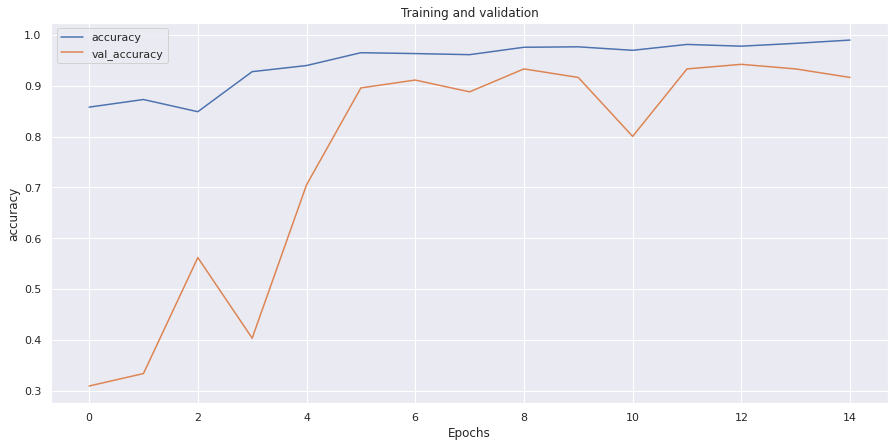

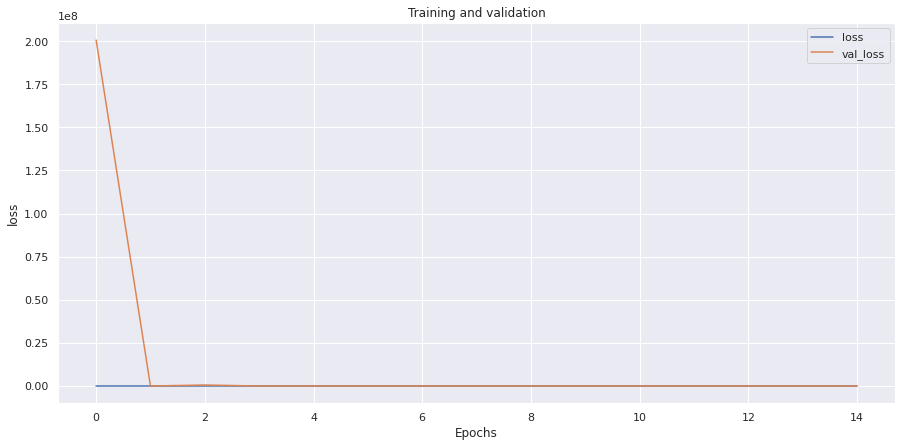

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_dn.save("dn1692.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
dn1692_model = load_model('dn1692.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = dn1692_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 14s 446ms/step - loss: 0.6259 - accuracy: 0.8710
test loss: 0.625934362411499
test acc: 0.8709677457809448


Using the ModelCheckpoint callback did allow DenseNet160 to achieve a higher accuracy, but it's still considerably lower than the accuracy of our inital model as well as InceptionV3. So, we'll drop DenseNet169 as well.

###InceptionV3 with ModelCheckpoint

In [ ]:
iv3 = tf.keras.applications.InceptionV3(
                  include_top=False,
                  input_shape=(224, 224, 3))

In [ ]:
#Adjust several layers
model_iv3 = tf.keras.Sequential()
model_iv3.add(iv3)
model_iv3.add(tf.keras.layers.Flatten())
model_iv3.add(tf.keras.layers.Dense(256, activation='relu'))
model_iv3.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_iv3.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='iv3.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_iv3.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 44s 600ms/step - loss: 0.0121 - accuracy: 0.9970 - val_loss: 0.2915 - val_accuracy: 0.9059

Epoch 00001: val_loss improved from inf to 0.29151, saving model to iv3.h5
Epoch 2/15
73/73 [==============================] - 43s 582ms/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.5608 - val_accuracy: 0.8827

Epoch 00002: val_loss did not improve from 0.29151
Epoch 3/15
73/73 [==============================] - 43s 586ms/step - loss: 0.0601 - accuracy: 0.9824 - val_loss: 1.4711 - val_accuracy: 0.5709

Epoch 00003: val_loss did not improve from 0.29151
Epoch 4/15
73/73 [==============================] - 43s 589ms/step - loss: 0.0913 - accuracy: 0.9687 - val_loss: 0.4512 - val_accuracy: 0.9059

Epoch 00004: val_loss did not improve from 0.29151
Epoch 5/15
73/73 [==============================] - 43s 584ms/step - loss: 0.0357 - accuracy: 0.9884 - val_loss: 0.4432 - val_accuracy: 0.9330

Epoch 00005: val_loss did not improve from 0.29151
E

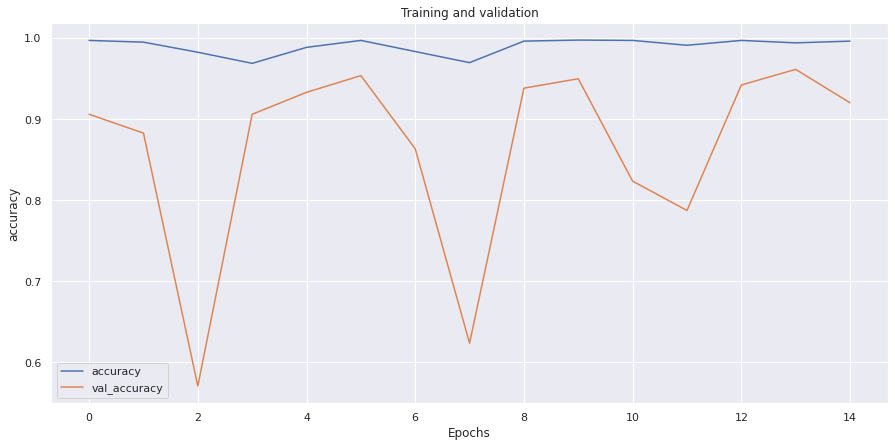

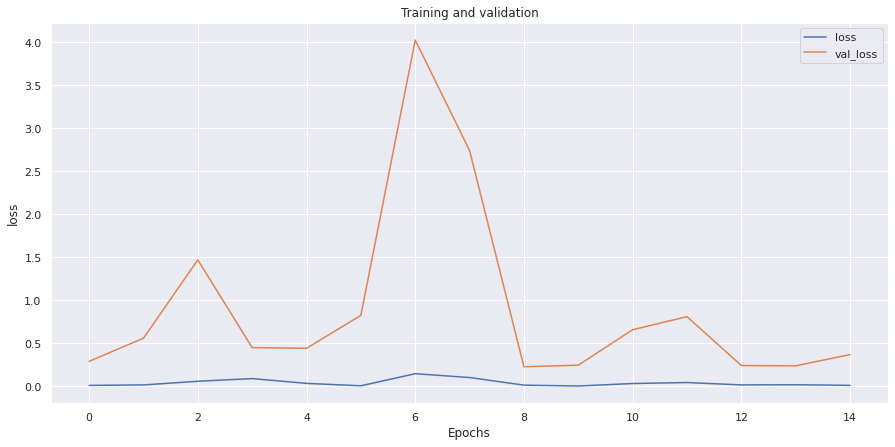

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_iv3.save("iv3.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
iv3_model = load_model('iv3.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = iv3_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 12s 431ms/step - loss: 0.7763 - accuracy: 0.8929
test loss: 0.7762936353683472
test acc: 0.892903208732605


While this test accuracy was a bit lower than the earlier InceptionV3 test accuracy, the use of ModelCheckpoint appears promising. We'll opt to keep this model for now, but may have to find a way to increase its consitency while also tuning it.

###InceptionResNetV2

As a late edition to this notebook, we'll also consider InceptionResnetV2 due to its high level of accuracy compared to many of the models tested above. However, before we can begin training, we need to change the size of our images because this particular model has a default image size of 299 x 299 rather than 224 x 224. 

In [31]:
train_batches_irnv2 = train_data_generator.flow_from_directory(train_path, 
                                                                   target_size=(299, 299), 
                                                                   classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                                   batch_size=32)
valid_batches_irnv2 = valid_data_generator.flow_from_directory(valid_path, 
                                                        target_size=(299, 299), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

test_batches_irnv2 = test_data_generator.flow_from_directory(test_path, 
                                                        target_size=(299, 299), 
                                                        classes=['COVID', 'NORMAL', 'Viral Pneumonia'], 
                                                        batch_size=32)

Found 2335 images belonging to 3 classes.
Found 776 images belonging to 3 classes.
Found 775 images belonging to 3 classes.


In [ ]:
irnv2 = tf.keras.applications.InceptionResNetV2(
                  include_top=False,
                  input_shape=(299, 299, 3))

In [ ]:
model_irnv2 = tf.keras.Sequential()
model_irnv2.add(irnv2)
model_irnv2.add(tf.keras.layers.Flatten())
model_irnv2.add(tf.keras.layers.Dense(256, activation='relu'))
model_irnv2.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
model_irnv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               25166080  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 79,503,587
Trainable params: 79,443,043
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
model_irnv2.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='irnv2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_irnv2.fit(train_batches_irnv2, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches_irnv2, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 89s 1s/step - loss: 1.5714e-04 - accuracy: 1.0000 - val_loss: 0.2835 - val_accuracy: 0.9562

Epoch 00001: val_loss improved from inf to 0.28354, saving model to irnv2.h5
Epoch 2/15
73/73 [==============================] - 94s 1s/step - loss: 8.8312e-05 - accuracy: 1.0000 - val_loss: 0.2971 - val_accuracy: 0.9562

Epoch 00002: val_loss did not improve from 0.28354
Epoch 3/15
73/73 [==============================] - 93s 1s/step - loss: 4.3738e-04 - accuracy: 1.0000 - val_loss: 0.3244 - val_accuracy: 0.9523

Epoch 00003: val_loss did not improve from 0.28354
Epoch 4/15
73/73 [==============================] - 94s 1s/step - loss: 1.1078e-04 - accuracy: 1.0000 - val_loss: 0.3190 - val_accuracy: 0.9510

Epoch 00004: val_loss did not improve from 0.28354
Epoch 5/15
73/73 [==============================] - 93s 1s/step - loss: 7.4041e-05 - accuracy: 1.0000 - val_loss: 0.2882 - val_accuracy: 0.9601

Epoch 00005: val_loss did not improve from 0.

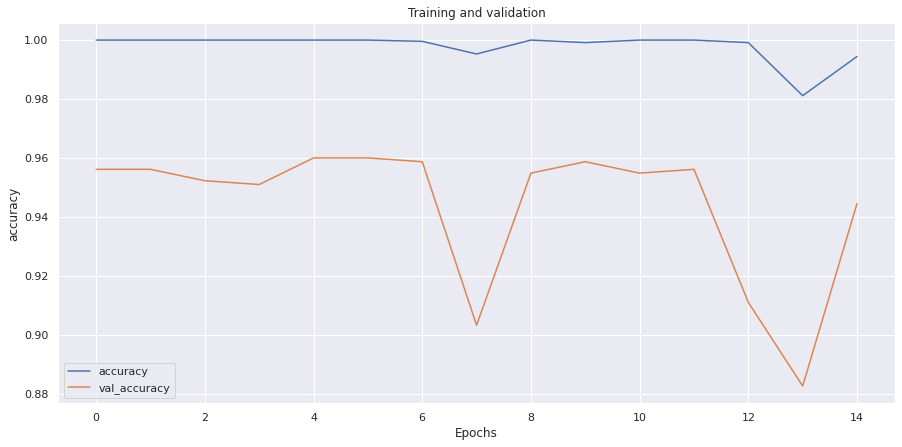

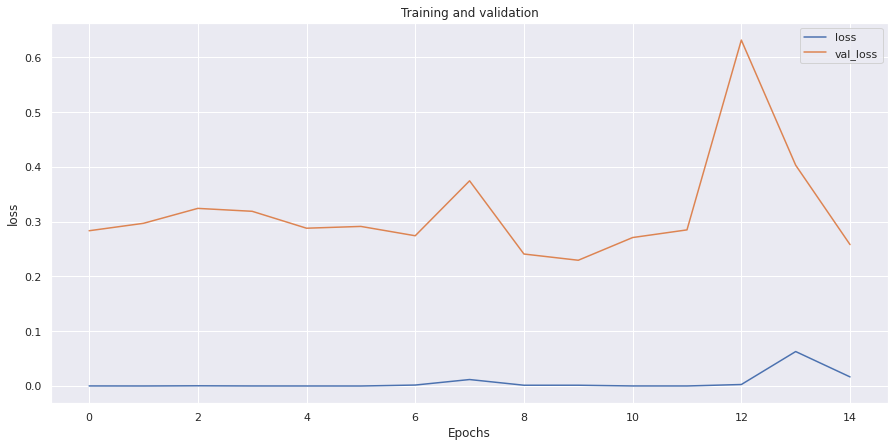

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Save the model
model_irnv2.save("irnv2.h5")

In [ ]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
irnv2_model = load_model('irnv2.h5')

In [ ]:
# Running the model on the test set
test_loss, test_acc = irnv2_model.evaluate(test_batches_irnv2, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 21s 512ms/step - loss: 0.3946 - accuracy: 0.9161
test loss: 0.39457976818084717
test acc: 0.9161290526390076


Compared to our other pretrained models, not only is the accuracy high for training, validation, and test sets but the accuracy is fairly consistent epoch to epoch. This is a very promising model that we'll tune in the next phase of the project. Though, overfitting will have to be addressed.

###InceptionV3 with Imagenet Weights

We mentioned earlier that we had previously run many of our pretrained models without Imagenet weights because they had performed so poorly with them. However, we had not had a chance to do that with InceptionV3. Let's do so now.

In [11]:
iv3im = tf.keras.applications.InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

87916544/87910968 [==============================] - 1s 0us/step


In [12]:
#Adjust several layers
model_iv3im = tf.keras.Sequential()
model_iv3im.add(iv3im)
model_iv3im.add(tf.keras.layers.Flatten())
model_iv3im.add(tf.keras.layers.Dense(256, activation='relu'))
model_iv3im.add(tf.keras.layers.Dense(3, activation='softmax'))

In [13]:
model_iv3im.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:

%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='iv3im.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_iv3im.fit(train_batches, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 2273s 31s/step - loss: 5.2177 - accuracy: 0.6615 - val_loss: 6314.7964 - val_accuracy: 0.3634

Epoch 00001: val_loss improved from inf to 6314.79639, saving model to iv3im.h5
Epoch 2/15
73/73 [==============================] - 47s 645ms/step - loss: 0.1643 - accuracy: 0.9485 - val_loss: 0.4742 - val_accuracy: 0.9227

Epoch 00002: val_loss improved from 6314.79639 to 0.47425, saving model to iv3im.h5
Epoch 3/15
73/73 [==============================] - 46s 632ms/step - loss: 0.0855 - accuracy: 0.9745 - val_loss: 0.4056 - val_accuracy: 0.9240

Epoch 00003: val_loss improved from 0.47425 to 0.40561, saving model to iv3im.h5
Epoch 4/15
73/73 [==============================] - 47s 644ms/step - loss: 0.0873 - accuracy: 0.9744 - val_loss: 0.8334 - val_accuracy: 0.7680

Epoch 00004: val_loss did not improve from 0.40561
Epoch 5/15
73/73 [==============================] - 46s 633ms/step - loss: 0.0556 - accuracy: 0.9816 - val_loss: 0.2679 - val

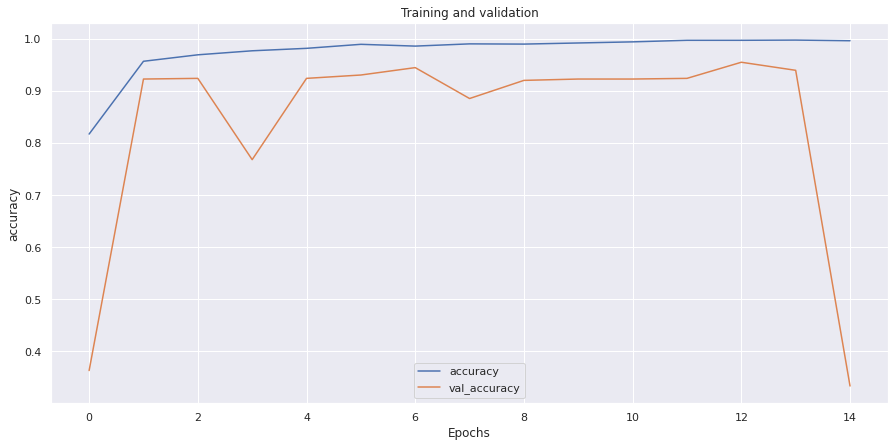

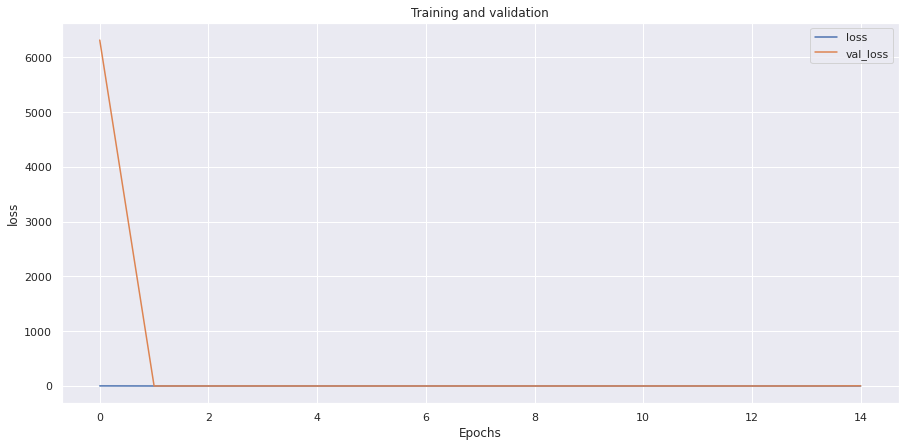

In [15]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
# Save the model
model_iv3im.save("iv3im.h5")

In [19]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
iv3im_model = load_model('iv3im.h5')

In [20]:
# Running the model on the test set
test_loss, test_acc = iv3im_model.evaluate(test_batches, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 569s 24s/step - loss: 0.3521 - accuracy: 0.9200
test loss: 0.35213562846183777
test acc: 0.9200000166893005


Not only did the model perform well, but it seemed to have much better consistency epoch to epoch than our model without Imagenet weights. So, we'll use this version of InceptionV3 in our next project phase. 

###InceptionResNetV2 with Imagenet Weights

Finally, as InceptionResNetV2 was a late addition to this notebook, we had not had a chance to train it using Imagenet weights. We'll do so below.

In [27]:
irnv2 = tf.keras.applications.InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=(299, 299, 3))

219062272/219055592 [==============================] - 2s 0us/step


In [28]:
model_irnv2 = tf.keras.Sequential()
model_irnv2.add(irnv2)
model_irnv2.add(tf.keras.layers.Flatten())
model_irnv2.add(tf.keras.layers.Dense(256, activation='relu'))
model_irnv2.add(tf.keras.layers.Dense(3, activation='softmax'))

In [29]:
model_irnv2.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
%%time

callbacks_list = [
    
    keras.callbacks.ModelCheckpoint(
        filepath='irnv2.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


# use this to grab batches from the image data generator
# tell model.fit about the validation data.
# steps per epoch size of dataset/batchsize . 2594/32
history = model_irnv2.fit(train_batches_irnv2, 
                    steps_per_epoch=73, 
                    callbacks=callbacks_list,
                    validation_data=valid_batches_irnv2, 
                    validation_steps=25, 
                    epochs=15, 
                    verbose = 1)

Epoch 1/15
73/73 [==============================] - 85s 876ms/step - loss: 7.3453 - accuracy: 0.7845 - val_loss: 0.8992 - val_accuracy: 0.8402

Epoch 00001: val_loss improved from inf to 0.89922, saving model to irnv2.h5
Epoch 2/15
73/73 [==============================] - 58s 789ms/step - loss: 0.0682 - accuracy: 0.9767 - val_loss: 0.7460 - val_accuracy: 0.7500

Epoch 00002: val_loss improved from 0.89922 to 0.74604, saving model to irnv2.h5
Epoch 3/15
73/73 [==============================] - 58s 797ms/step - loss: 0.0727 - accuracy: 0.9735 - val_loss: 0.1578 - val_accuracy: 0.9575

Epoch 00003: val_loss improved from 0.74604 to 0.15778, saving model to irnv2.h5
Epoch 4/15
73/73 [==============================] - 58s 791ms/step - loss: 0.0614 - accuracy: 0.9816 - val_loss: 0.4889 - val_accuracy: 0.9188

Epoch 00004: val_loss did not improve from 0.15778
Epoch 5/15
73/73 [==============================] - 58s 796ms/step - loss: 0.0897 - accuracy: 0.9803 - val_loss: 20.8203 - val_accurac

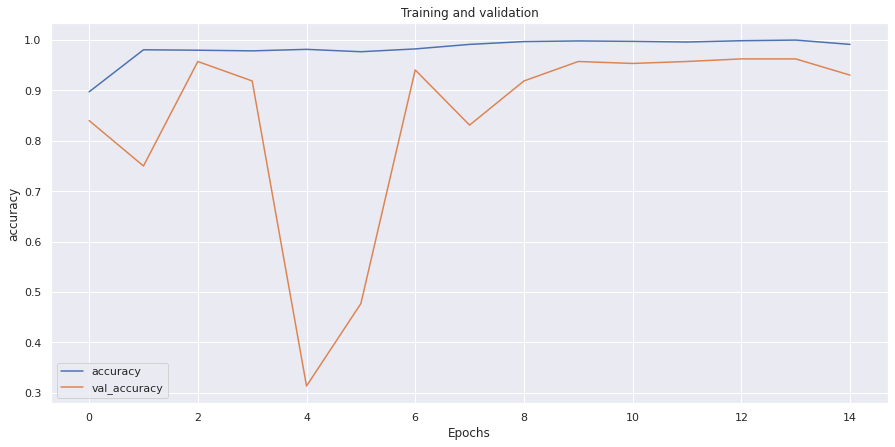

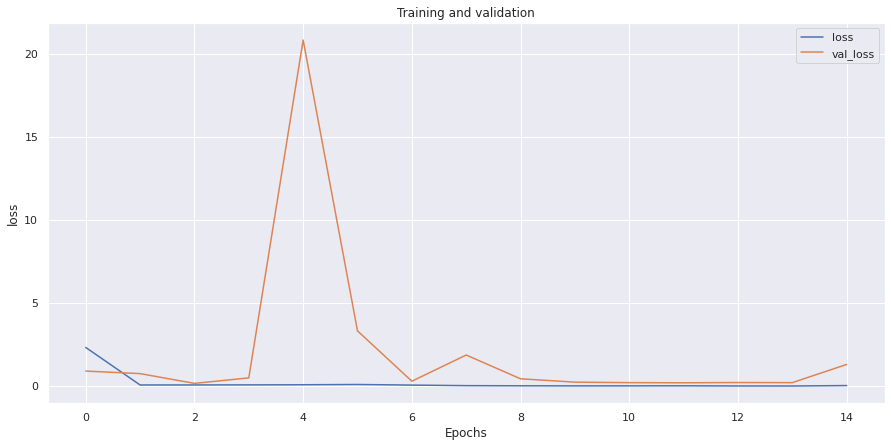

In [33]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [34]:
# Save the model
model_irnv2.save("irnv2_model")

INFO:tensorflow:Assets written to: irnv2_model/assets


In [35]:
# restore the model and do some test set evaluation.
from tensorflow.keras.models import load_model
irnv2_model = load_model('irnv2_model')

In [36]:
# Runninng the model on the test set
test_loss, test_acc = irnv2_model.evaluate(test_batches_irnv2, steps=25)
print('test loss:', test_loss)
print('test acc:', test_acc)

25/25 [==============================] - 20s 638ms/step - loss: 0.8923 - accuracy: 0.9123
test loss: 0.8923289179801941
test acc: 0.9122580885887146


This model appears to have performed worse with Imagenet weights than without them and showed more inconsistency on the validation set. So'll stick with the latter model.

Moving onto the next phase of this project, where we'll attempt to tune our models, the three models that we'll be tuning will be our inital model, InceptionV3 with Imagenet weights, and InceptionResnetV2 without Imagenet.